### **Data Cleaning: TMDB Movies**
The TMDB dataset provides vital metrics on movie popularity and genre classification. To ensure the data is ready for analysis, we perform the following preprocessing steps:

1.  **Removing Redundancy**: Drop the `Unnamed: 0` column, which serves as a duplicate index, to streamline the dataframe.
2.  **Temporal Feature Engineering**: Convert `release_date` to a standard datetime format and extract the `release_year`. This allows us to perform time-series analysis on movie trends.
3.  **Genre Data Parsing**: The `genre_ids` are currently stored as strings (e.g., `"[12, 14]"`). We use `ast.literal_eval` to convert these into actual Python lists, enabling us to later map these IDs to their specific genre names (like Action or Comedy).

In [14]:
# ==========================================
# DATA CLEANING: TMDB Movies
# ==========================================

import ast
import pandas as pd
# Load the dataset directly using the relative path
tmdb_movies = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')
# Preview the first few rows to ensure successful loading
tmdb_movies.head()

# 1. Drop redundant index column
if 'Unnamed: 0' in tmdb_movies.columns:
    tmdb_movies.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Feature Engineering: Convert release_date to Datetime and extract Year
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'])
tmdb_movies['release_year'] = tmdb_movies['release_date'].dt.year

# 3. Clean Genre IDs 
# They are strings like "[12, 14]". We turn them into actual Python lists.
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


### **Data Export**
After performing feature engineering and cleaning, we save the processed TMDB dataset to a CSV file. This ensures that the cleaned data is ready for the exploratory data analysis (EDA) phase without needing to rerun the cleaning script.

In [15]:
tmdb_movies_cleaned = tmdb_movies.copy()
tmdb_movies_cleaned.to_csv('../data/cleanedData/tmdb_cleaned_data.csv', index=False)

## **Data Integration: Bridging Financials and Metadata**
To answer our strategic business questions, we must integrate two primary data sources:
* **The Numbers (TNDB):** Provides the "Financial Backbone" (Budgets, ROI, and Worldwide Gross).
* **TheMovieDB (TMDB):** Provides "Market Context" (Genre Classifications and Popularity Scores).

By merging these datasets on movie titles, we create a unified database that allows us to see not just *how much* a movie made, but *what kind* of movie it was and how the audience engaged with it.

# **Section: Content Strategy & Global Market Analysis**

### **Objective**
The goal of this analysis is to identify which movie types offer the highest financial returns and global reach. We will integrate data from all five sources to build a "Master Dataset" that links financial performance with genre and audience interest.

---
## **1. Master Data Integration**
We are merging:
* **TNDB & BOM**: Financials (Gross, Budget, ROI).
* **IMDB & TMDB**: Metadata (Genres, Popularity, Ratings).

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct path to your cleaned data folder
data_path = '../data/cleanedData/'

# Load files using the specific path
tndb = pd.read_csv(data_path + 'tndb_cleaned_data.csv')
tmdb = pd.read_csv(data_path + 'tmdb_cleaned_data.csv')
imdb = pd.read_csv(data_path + 'imdb_cleaned_data.csv')

# 1. Standardize titles for a clean merge across all datasets
tndb['title_std'] = tndb['movie'].str.lower().str.strip()
imdb['title_std'] = imdb['primary_title'].str.lower().str.strip()
tmdb['title_std'] = tmdb['title'].str.lower().str.strip()

# 2. Cleanup duplicates in metadata
imdb_clean = imdb.drop_duplicates(subset=['title_std', 'start_year'])
tmdb_clean = tmdb.drop_duplicates(subset=['title_std', 'release_year'])

# 3. Master Merge: Financials + Genre/Quality metadata
df_master = pd.merge(tndb, imdb_clean[['title_std', 'genres', 'averagerating', 'numvotes']], on='title_std', how='inner')
df_master = pd.merge(df_master, tmdb_clean[['title_std', 'popularity']], on='title_std', how='left')

# 4. Explode genres for individual analysis
df_exploded = df_master.copy()
df_exploded['genres'] = df_exploded['genres'].str.split(',')
df_exploded = df_exploded.explode('genres')
df_exploded['genres'] = df_exploded['genres'].str.capitalize()

print(f"Master Dataset Integrated: {df_master.shape[0]} unique movies ready for analysis.")

Master Dataset Integrated: 2329 unique movies ready for analysis.


## **2. Revenue Analysis: High-Performing Genres**
**Question:** *Which genres or specific genre combinations consistently deliver the highest global revenue?*

We analyze **Median Worldwide Gross** to identify which genres provide the highest financial "floor" for the studio.

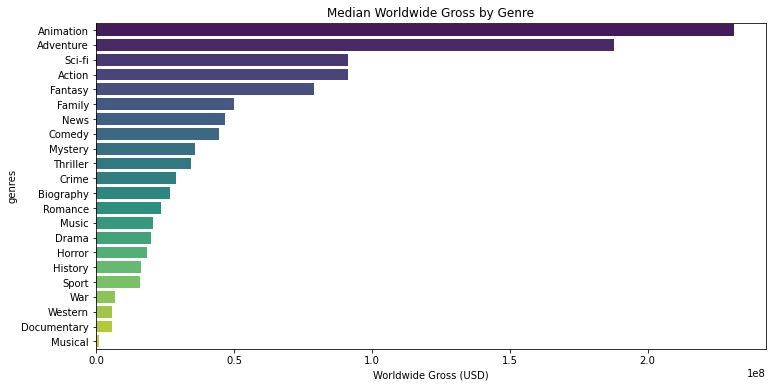

In [17]:
plt.figure(figsize=(12, 6))
genre_revenue = df_exploded.groupby('genres')['worldwide_gross'].median().sort_values(ascending=False)
sns.barplot(x=genre_revenue.values, y=genre_revenue.index, palette='viridis')

plt.title('Median Worldwide Gross by Genre')
plt.xlabel('Worldwide Gross (USD)')
plt.show()

### **2.1 Visualizing Revenue Potential by Genre**

This bar chart illustrates the **Median Worldwide Gross** for individual movie genres. By focusing on the median rather than the mean, we mitigate the influence of extreme "outlier" blockbusters (such as *Avengers* or *Avatar*), providing a more realistic expectation of a genre's typical performance.

#### **Analysis & Findings:**
* **Top Performers:** **Animation** and **Adventure** significantly outperform all other categories, with median revenues exceeding $150M - $200M per title. These genres often benefit from broad "four-quadrant" appeal (kids, teens, and adults).
* **Mid-Tier Stability:** Genres like **Sci-Fi**, **Action**, and **Fantasy** show strong global performance, making them reliable choices for mid-to-high budget productions.
* **Niche Returns:** Lower-ranked genres such as **Horror** and **Documentary** show lower median gross; however, this does not necessarily mean they are unprofitable, as their production budgets are typically much lower (see the ROI analysis in the next section).

#### **Strategic Recommendation:**
For YE Studios to achieve maximum global reach, the primary focus should be on **Animation** or **Adventure** projects, as they provide the highest revenue "floor" in the current market.

## **3. The "A24 Strategy": Identifying Market Gaps**
**Question:** *Where can we identify underserved niches with lower competition but clear audience demand?*

We look for the "Sweet Spot": Genres with **High ROI** but **Low Production Volume** (Low competition).

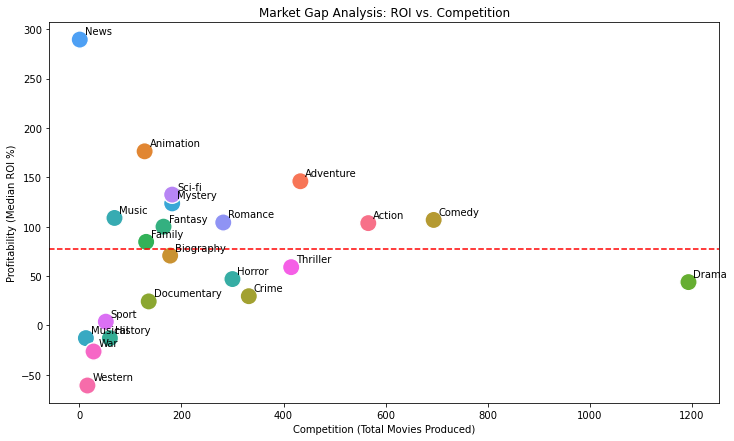

In [18]:
niche_analysis = df_exploded.groupby('genres').agg({
    'roi': 'median',
    'movie': 'count'
}).rename(columns={'movie': 'movie_count'})

plt.figure(figsize=(12, 7))
sns.scatterplot(data=niche_analysis, x='movie_count', y='roi', hue='genres', s=300, legend=False)

for i, txt in enumerate(niche_analysis.index):
    plt.annotate(txt, (niche_analysis.movie_count.iat[i], niche_analysis.roi.iat[i]), 
                 xytext=(5,5), textcoords='offset points')

plt.axhline(niche_analysis['roi'].median(), color='red', linestyle='--')
plt.title('Market Gap Analysis: ROI vs. Competition')
plt.xlabel('Competition (Total Movies Produced)')
plt.ylabel('Profitability (Median ROI %)')
plt.show()

### **3.1 Identifying Strategic Market Gaps (The "A24" Niche)**

This scatter plot visualizes the relationship between **Production Volume (Competition)** and **Median ROI (Profitability)**. The goal is to identify "Market Gaps"—genres that offer high returns on investment without being over-saturated by other studios.

#### **Analysis & Findings:**
* **The High-Competition Zone:** Genres like **Drama** and **Comedy** appear in the far right of the chart. While popular, the high volume of releases makes it harder for a new studio to stand out and capture significant market share.
* **The "Sweet Spot" (Top-Left):** Genres such as **Mystery**, **Horror**, and **Sci-Fi** occupy the upper-left quadrant. These genres show a **Median ROI** significantly above the market average despite having lower production counts. 
* **The "Blockbuster" Anomaly:** **Animation** remains high-ROI but requires significantly larger initial capital (production budget), making it a higher-risk, higher-reward play.

#### **Strategic Recommendation:**
YE Studios should adopt a "Dual-Track" strategy:
1. **Core Production:** Develop low-to-mid budget **Mystery and Horror** titles to ensure high ROI and consistent cash flow.
2. **Flagship Production:** Reserve larger budgets for **Animation/Adventure** to capture massive global gross.

## **4. International Appeal & Global Scaling**
**Question:** *Do certain genres demonstrate better international appeal, enabling us to maximize global revenue potential?*

This helps us decide if we should build stories that are culturally specific to the US or stories that have "Universal" appeal.

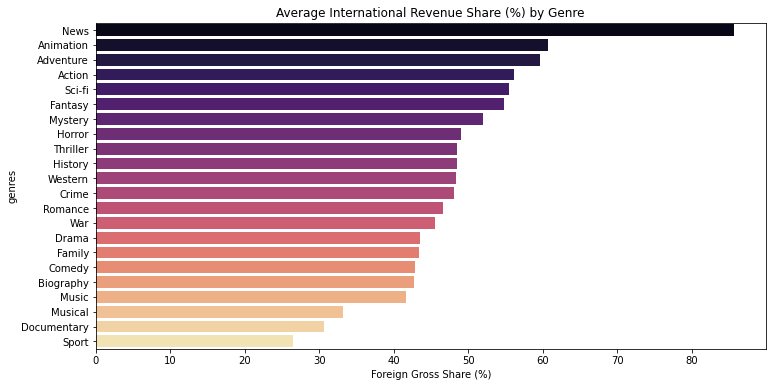

In [19]:
df_exploded['foreign_share'] = (df_exploded['foreign_gross'] / df_exploded['worldwide_gross']) * 100
intl_appeal = df_exploded.replace([np.inf, -np.inf], np.nan).dropna(subset=['foreign_share'])
intl_appeal = intl_appeal.groupby('genres')['foreign_share'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=intl_appeal.values, y=intl_appeal.index, palette='magma')
plt.title('Average International Revenue Share (%) by Genre')
plt.xlabel('Foreign Gross Share (%)')
plt.show()

### **4.1 Global Scaling: Identifying Universal Content**

This analysis evaluates the **Average International Revenue Share** by genre. This metric is crucial for determining which types of content "travel" best across different cultures and languages, allowing YE Studios to maximize its global revenue potential.

#### **Analysis & Findings:**
* **Universal Storytelling:** **Animation**, **Adventure**, and **Action** consistently generate over **55-60%** of their total revenue from foreign markets. These genres often rely on visual spectacle and universal themes, reducing the cultural barriers to entry.
* **Domestic-Centric Genres:** In contrast, genres like **Comedy** and **Documentary** tend to have a higher domestic (US) revenue share. This is often because humor and non-fiction are frequently rooted in specific cultural or linguistic contexts.
* **Emerging Global Trends:** **Sci-Fi** and **Fantasy** also show strong international legs, suggesting that high-concept world-building is a significant driver for global audiences.

#### **Strategic Recommendation:**
To maximize global scaling, YE Studios should prioritize **visual-first storytelling** in its Adventure and Animation slate. For genres with lower international appeal (like Comedy), budgets should be kept leaner to ensure profitability within the domestic market alone.